# Imports

In [10]:
import ray

ray.shutdown()

In [37]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("tmp/bokeh_output.html")
# import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# .describe(include='all', datetime_is_numeric=True)
# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sample tick dates

In [12]:
from bar_sampler import meta, sampler, stacked
from data_model import arrow_dataset, s3_backend

thresh = {
    # meta params
    'symbol': 'KL',
    'start_date': '2019-10-10',
    'end_date': '2019-10-15',
    # filter
    'mad_value_winlen': 22,
    'mad_deviation_winlen': 1111,
    'mad_k': 17,  # 11
    'mad_diff': 'simple',
    'jma_winlen': 7,
    'jma_power': 2,
    # time batcher
    'batch_freq': '2s',
    # bar sampler params
    'renko_return': 'price_jma_return',
    'renko_size': 0.1,  # for simple runs
    'renko_reveral_multiple': 2,
    'renko_range_frac': 22,
    'renko_range_min_pct_value': 0.03,  # X% of symbol value to enforc min renko size
    'max_duration_td': dt.timedelta(minutes=33),
    'min_duration_td': dt.timedelta(seconds=33),
    'min_tick_count': 33,
    # label params
    'add_label': True,
    'reward_ratios': list(np.arange(2, 11, 0.5)),
}

In [6]:
symbs = s3_backend.list_symbols('trades')
symbs

['AEM',
 'AG',
 'AGI',
 'ASA',
 'AU',
 'AUY',
 'AXU',
 'BTG',
 'BVN',
 'CDE',
 'DRD',
 'EGO',
 'EXK',
 'FNV',
 'FSM',
 'GFI',
 'GLD',
 'GORO',
 'GSS',
 'HL',
 'HMY',
 'IAG',
 'KGC',
 'KL',
 'MAG',
 'MUX',
 'NEM',
 'NG',
 'OR',
 'PAAS',
 'PVG',
 'RGLD',
 'SA',
 'SAND',
 'SSRM',
 'SVM',
 'USAS',
 'VTI',
 'WPM']

In [13]:
# bd = meta.get_bar_date(thresh, date='2019-01-10')

bds = meta.get_bar_dates(thresh, ray_on=True)


2021-05-22 22:14:31,770	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:1111


(pid=44099) KL 2019-10-14 trying to get data from local file...
(pid=44099) KL 2019-10-14 trying to get data from local file...
(pid=44100) KL 2019-10-09 trying to get data from local file...
(pid=44100) KL 2019-10-09 trying to get data from local file...
(pid=44097) KL 2019-10-11 trying to get data from local file...
(pid=44097) KL 2019-10-11 trying to get data from local file...
(pid=44098) KL 2019-10-10 trying to get data from local file...
(pid=44098) KL 2019-10-10 trying to get data from local file...
(pid=44099) KL 2019-10-15 trying to get data from local file...
(pid=44099) KL 2019-10-15 trying to get data from local file...


<AxesSubplot:>

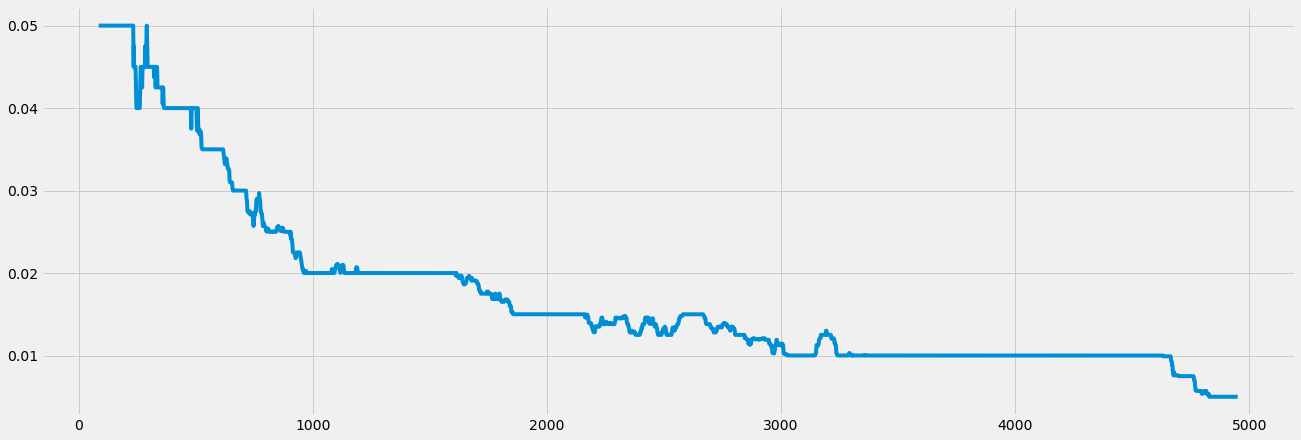

In [31]:
n = 3

# bds[n]['ticks_df'].price_median_diff_median.plot_bokeh(sizing_mode="scale_height")
bds[n]['ticks_df'].price_median_diff_median.plot()

<AxesSubplot:>

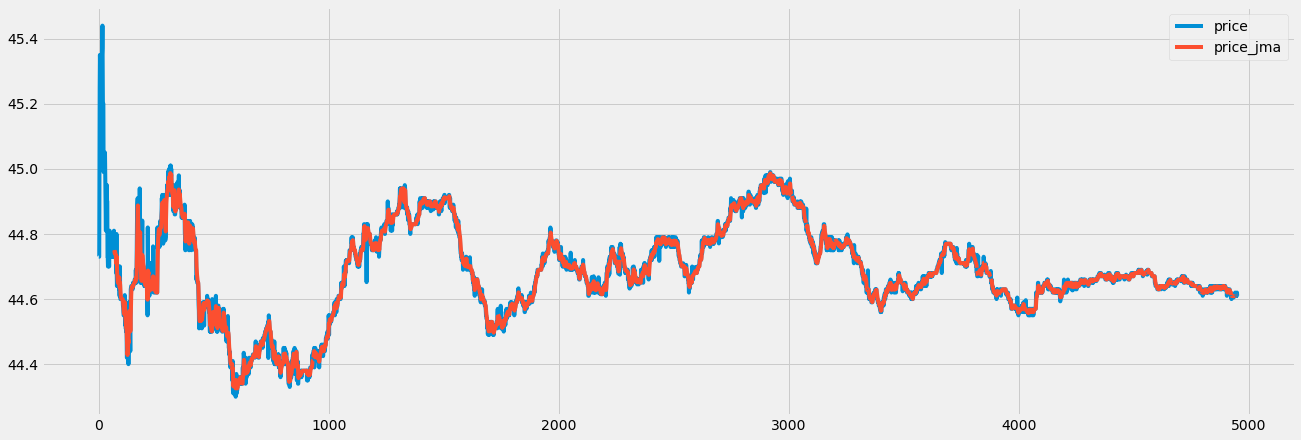

In [32]:
bds[n]['ticks_df'][['price', 'price_jma']].plot()

# bds[n]['ticks_df'][['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")

<AxesSubplot:xlabel='nyc_dt'>

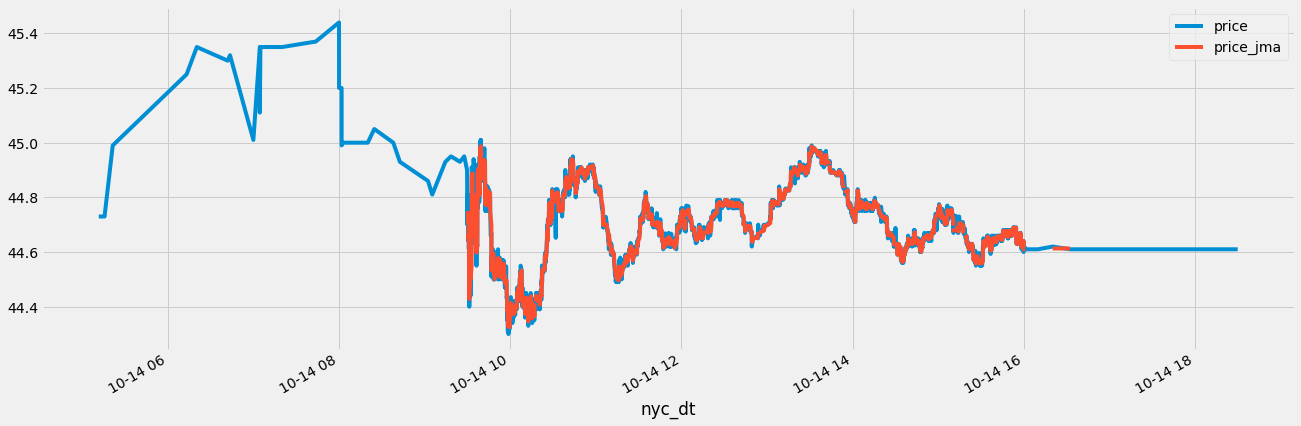

In [33]:
bds[n]['ticks_df'].set_index('nyc_dt')[['price', 'price_jma']].plot()
# bds[n]['ticks_df'].set_index('nyc_dt')[['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")

<AxesSubplot:>

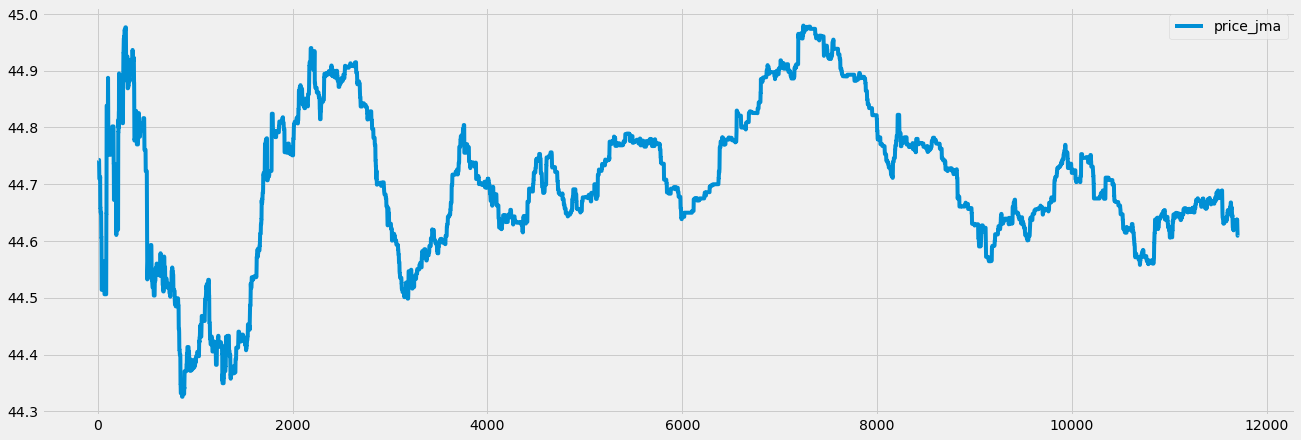

In [34]:
# bds[n]['batches_df'].set_index('close_at')[['price_jma']].ffill().plot()
bds[n]['batches_df'][['price_jma']].ffill().plot()

<AxesSubplot:>

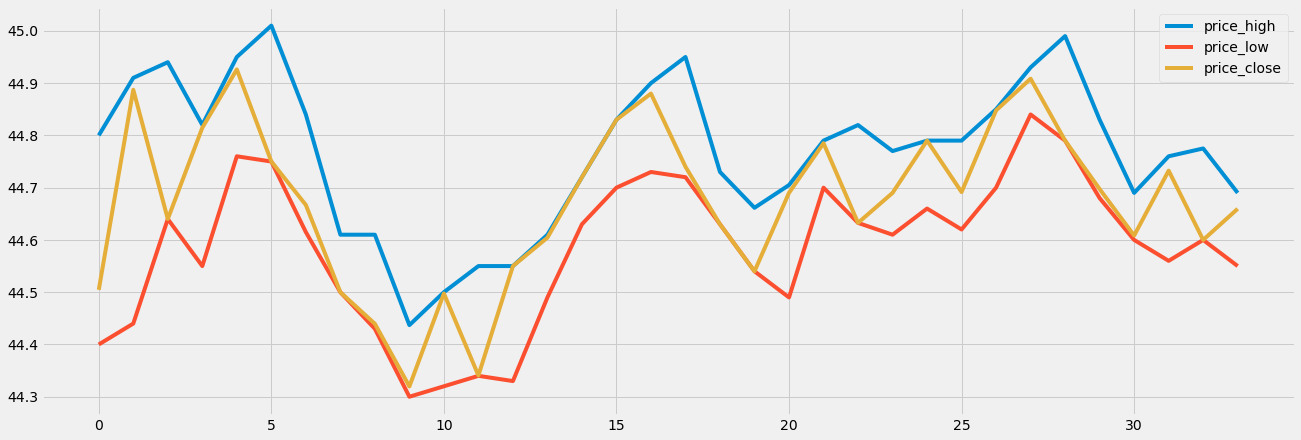

In [35]:
# bds[n]['bars_df'].set_index('close_at')[['price_vwap']].plot()

bds[n]['bars_df'][['price_high', 'price_low', 'price_close']].plot()

# opening_bars_df = bds[n]['bars_df'][bds[n]['bars_df'].open_at.dt.time <= dt.time(hour=9, minute=35)]

In [36]:
t=bds[n]['bars_df'].copy()
t.label_rrr.value_counts()/t.shape[0]

0.000000    0.323529
2.000000    0.117647
4.000000    0.058824
-2.500000   0.058824
-2.000000   0.058824
-4.000000   0.058824
5.000000    0.029412
-3.000000   0.029412
-8.500000   0.029412
-3.500000   0.029412
-6.500000   0.029412
8.500000    0.029412
2.500000    0.029412
7.000000    0.029412
3.000000    0.029412
3.500000    0.029412
6.000000    0.029412
Name: label_rrr, dtype: float64

In [22]:
# fill daily gaps
stacked_df = stacked.fill_gaps_dates(bds, fill_col='price_vwap')

# stacked stats
stats_df = stacked.stacked_df_stats(stacked_df)

stats_df

,date,bar_count,duration_min_median,price_range_mean,first_bar_open,last_bar_close
0,2019-10-09,62,4.916667,0.145276,2019-10-09 09:31:48-04:00,2019-10-09 15:59:56-04:00
1,2019-10-10,80,2.100000,0.161551,2019-10-10 09:30:04-04:00,2019-10-10 15:49:42-04:00
2,2019-10-11,81,2.033333,0.178694,2019-10-11 09:30:02-04:00,2019-10-11 15:57:26-04:00
3,2019-10-14,34,6.400000,0.184138,2019-10-14 09:30:24-04:00,2019-10-14 15:57:32-04:00
4,2019-10-15,50,3.983333,0.150860,2019-10-15 09:30:14-04:00,2019-10-15 15:48:22-04:00


In [23]:
stats_df.describe()

# stacked_df[['price_high','price_low','price_close', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

,bar_count,duration_min_median,price_range_mean
count,5.000000,5.000000,5.000000
mean,61.400000,3.886667,0.164104
std,20.069878,1.871771,0.016961
min,34.000000,2.033333,0.145276
25%,50.000000,2.100000,0.150860
50%,62.000000,3.983333,0.161551
75%,80.000000,4.916667,0.178694
max,81.000000,6.400000,0.184138


In [24]:
results = []

for date in bds:
    bars_df = date['bars_df'].copy()
    rrr = (abs(bars_df.label_rrr).value_counts() / bars_df.shape[0]).to_dict()
#     rrr = (abs(bars_df.label_rrr).value_counts()).to_dict()
    out = (date['ticks_df'].status.value_counts() / date['ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    out.update(rrr)
    results.append(out)

pd.DataFrame(results)

,clean,filtered: irregular conditions,filtered: MAD warm-up,filtered: ts diff,filtered: zero volume,filtered: MAD outlier,date,0.0,2.5,4.0,2.0,3.0,7.5,6.5,5.0,4.5,7.0,3.5,8.5,10.0,8.0,5.5,6.0,10.5,9.5,9.0
0,0.981457,0.010452,0.007530,0.000225,0.000225,0.000112,2019-10-09,0.290323,0.129032,0.096774,0.096774,0.080645,0.064516,0.032258,0.032258,0.032258,0.032258,0.016129,0.016129,0.016129,0.016129,0.016129,0.016129,0.016129,NaN,NaN
1,0.989393,0.005233,0.004738,NaN,0.000141,0.000495,2019-10-10,0.250000,0.112500,0.062500,0.100000,0.050000,0.025000,0.012500,0.050000,0.037500,0.025000,0.050000,0.012500,NaN,0.012500,NaN,0.025000,0.150000,0.025000,NaN
2,0.987655,0.007103,0.004621,0.000138,0.000138,0.000345,2019-10-11,0.296296,0.160494,0.037037,0.061728,0.049383,0.012346,0.024691,0.024691,0.037037,0.024691,0.049383,NaN,0.012346,NaN,NaN,0.024691,0.135802,0.037037,0.012346
3,0.975359,0.010705,0.013533,NaN,0.000404,NaN,2019-10-14,0.323529,0.088235,0.117647,0.176471,0.058824,NaN,0.029412,0.029412,NaN,0.029412,0.058824,0.058824,NaN,NaN,NaN,0.029412,NaN,NaN,NaN
4,0.989027,0.003575,0.005570,0.000333,0.000166,0.001330,2019-10-15,0.360000,0.060000,0.080000,0.120000,0.040000,NaN,0.020000,0.060000,0.060000,0.040000,0.080000,NaN,NaN,NaN,0.040000,0.020000,NaN,0.020000,NaN
